In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torch
import glob

import bvcopula

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
path = '/home/nina/models'

In [3]:
out_dir = '../models/'+exp_pref
with open(out_dir+'/summary.pkl','rb') as f:
    data = pkl.load(f)
n1=2
n2=20
data[n1+5,n2+5][0]

[FrankCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), IndependenceCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

In [4]:
def stimMI(copula, alpha=0.05, sem_tol=1e-3, mc_size=10000):
    '''
    Estimates the mutual information between a pair of uniformely
    distributed copula-transformed variables and the conditioning variable
    with the Robbins-Monro algorithm over responses.
    Parameters
    ----------
    pS : Tensor
        Prior over stimuli P(S). TODO: this, now assume uniform!
    alpha : float, optional
        Significance level of the entropy estimate.  (Default: 0.05)
    sem_tol : float, optional
        Maximum standard error as a stopping criterion.  (Default: 1e-3)
    mc_size : integer, optional
        Number of samples that are drawn in each iteration of the Monte
        Carlo estimation.  (Default: 10000)
    Returns
    -------
    ent : float
        Estimate of the mixed vine entropy in bits.
    sem : float
        Standard error of the mixed vine entropy estimate in bits.
    '''

    # Gaussian confidence interval for sem_tol and level alpha
    conf = torch.erfinv(torch.tensor([1. - alpha]))
    batch_shape = self.batch_shape[1:] #first dm is number of copulas, discard it
    #assume that batch_shape = []
    sem = torch.ones(batch_shape)*float('inf')
    ent = torch.zeros(batch_shape) #theta here must have dims: copula x batch dims
    var_sum = torch.zeros(batch_shape)
    log2 = torch.tensor([2.]).log()
    k = 0
    with torch.no_grad():
        while torch.any(sem >= sem_tol):
            # Generate samples
            samples = self.rsample(sample_shape = torch.Size([mc_size]))
            logp = self.log_prob(samples) # [sample dim, batch dims]
            assert torch.all(logp==logp)
            assert torch.all(logp.abs()!=float("inf")) #otherwise make masked tensor below
            log2p = logp / log2 #maybe should check for inf 2 lines earlier
            k += 1
            # Monte-Carlo estimate of entropy
            ent += (-log2p.mean(dim=0) - ent) / k # mean over samples dimension
            # Estimate standard error
            var_sum += ((-log2p - ent) ** 2).sum(dim=0)
            sem = conf * (var_sum / (k * mc_size * (k * mc_size - 1))).pow(.5)
    return ent#, sem

In [5]:
import warnings
import sys
import traceback
from tqdm import tqdm
    
def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))
    
def get_model(n1,n2,likelihoods,device):
    get_weights_filename = glob.glob('{}/{}/model_{}-{}.pth'.format(path,exp_pref,n1,n2))
    print(get_weights_filename)
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
            return 0
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        return model
    else:
        print('Weights file {} not found.'.format(get_weights_filename))
        return 0
        
def measure_MI(model,points,samp_mc_size=10000):
    MIs = []
    with torch.no_grad():
        fs = model(points).rsample(torch.Size([5])) #[samples_f, copulas, positions]
    f_mean = model(points).mean.unsqueeze(0)
    # now add mean f to a set of f samples
    fs = torch.cat((fs,f_mean),0) #[samples_f + 1, copulas, positions]
    #fs = torch.einsum('ijk->jik', fs) #[copulas, samples_f + 1, positions] 
    
    #f = fs.reshape((fs.shape[0],-1)) #[copulas, ( (samples_f + 1) x positions)]

    copula = model.likelihood(fs)
    MIs = copula.entropy()
    #MIs = MI.reshape(fs.shape[1:]) #[(samples_f + 1), positions]
    MI_mean = MIs[-1]
    MIs = MIs[:-1]

    return (MI_mean,MIs.mean(dim=0),MIs.std(dim=0))

warnings.showwarning = warn_with_traceback

points = torch.linspace(0,1,20)
        
n1=1
n2=4

print(data[n1+5,n2+5][1])

%time model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (ym, y, dy) = measure_MI(model, points)

FrankGaussian
['/home/nina/models/ST263_Day4/model_1-4.pth']
CPU times: user 985 ms, sys: 0 ns, total: 985 ms
Wall time: 45.3 ms
CPU times: user 19min 44s, sys: 11.7 s, total: 19min 55s
Wall time: 40 s


In [6]:
torch.zeros(2).dim()

1

(-0.5, 0)

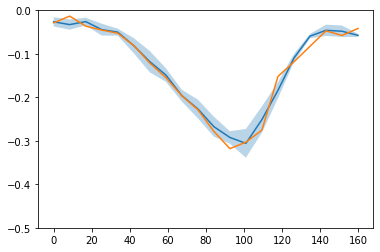

In [7]:
plt.plot(np.linspace(0,160,len(y)),y)
plt.fill_between(np.linspace(0,160,len(y)),y-dy,y+dy, alpha=0.3)
plt.plot(np.linspace(0,160,len(ym)),ym)
plt.ylim(-.5,0)

In [8]:
def input_information(model, n: int, scale: float, samp_mc_size=100, device=torch.device('cpu')):
        ds = scale/n #scale determines units of ds
        
        points = torch.linspace(0,1,n+3)

        with torch.no_grad():
            fs = model(points).rsample(torch.Size([20])) #[samples_f, copulas, positions]
        fs = torch.einsum('ijk->jki', fs) #[copulas, positions, samples_f] 
        f = fs.reshape((fs.shape[0],-1)) #[copulas, (samples_f x positions)]
            
        copula = model.likelihood._get_copula(f, sample_size = torch.Size([samp_mc_size]))
        samples = copula.rsample()
        logprob = copula.log_prob(samples)
        
        logprob = logprob.reshape((*fs.shape[1:],-1)) #[positions, samples_f]

        #calculate FI
        FI = torch.zeros_like(logprob[...,0])
        for i in range(1,n):
            FI[i] = ((logprob[i].exp())*((logprob[i+1]-logprob[i-1])/ds).pow(2)).sum(dim=-1)
            if (i>2) & (i<n-1):
                
#             #now calculate MI    
#             # P(r) = integral P(r|s) P(s) ds
#             Pr = torch.zeros(samples.shape[0]).cuda(device=get_cuda_device)
#             for i in range(n+1):
#                 Pr += logprob[i].exp().detach()*(1/(n+1))
#             MIs=0
#             for i in range(n+1):    
#                 MIs+= 1/(n+1)*logprob[i].exp()*(logprob[i]-Pr.log()) # sum p(r|s) * log p(r|s)/p(r)
#             MI = MIs.sum()     
        return (FI.mean(dim=-1),FI.std(dim=-1))

model = get_model(n1, n2, data[n1+5,n2+5][0], torch.device('cpu')) 
%time (FI, dFI) = input_information(model, 160, 160, device=torch.device('cpu'))

IndentationError: expected an indented block (<ipython-input-8-1edd0510d82b>, line 32)

In [ ]:
plt.plot(np.linspace(0,160,len(FI)),FI)
plt.fill_between(np.linspace(0,160,len(FI)),FI-dFI,FI+dFI, alpha=0.3)